# Analyzing Boston Marathon Data Through Clustering

In this study, clustering techniques were used on data from the 2014 Boston Marathon to gain an understanding of how different observations may be related. These techniques focused on utilizing factors related to the individual participants in the event. Sillhouette scores were used to evaluate clusters and analysis was done on individual clusters to better ascertain how divisions were made.

In [1]:
%%time

import math
import re
import warnings

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="sklearn"  
    )


# Set Plot Style
sns.set_style('darkgrid')


CPU times: user 1.36 s, sys: 241 ms, total: 1.6 s
Wall time: 893 ms


In [2]:
## Import Data

df = pd.read_csv("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv", header=None, error_bad_lines=False)

In [3]:
## View Data for Cleaning

#df.head(7)
#df.dtypes
#df.describe()
#df.isnull().sum(axis = 0)
#len(df)

In [4]:
## Rename Columns

df.columns = list(df.iloc[0,:])
df = df.drop(df.index[0])
df = df.reset_index(drop=True)

In [5]:
## Change Data Types

df = df.apply(pd.to_numeric, errors='ignore')
df[['10k', '25k','35k','30k',
    '5k','half','20k','40k']] = df[['10k', '25k','35k','30k',
                                    '5k','half','20k','40k']].apply(pd.to_numeric, errors='coerce')

In [6]:
## Drop Null Values

df = df.drop('ctz',axis=1).dropna()
df = df.reset_index(drop=True)


## Initial Data Analysis


In [7]:
df.head(7)

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,30.480,"Hall, Ryan",20,77.680,M,31,137.830,6,20,112.270,20,5.270,CA,94.780,15.150,65.230,61.780,USA,Redding,129.830
1,17.120,"Cassidy, Josh R.",13,48.880,M,29,87.400,W8,13,72.830,13,3.350,ON,60.820,8.020,40.200,38.020,CAN,Port Elgin,82.380
2,33.930,"Linden, Desiree",10,85.030,F,30,143.900,F8,10,119.680,46,5.500,MI,102.400,16.920,71.680,67.920,USA,Rochester Hills,136.470
3,18.300,"Filteau, Michel",14,50.330,M,47,89.400,W13,14,74.950,14,3.420,QC,62.330,8.670,41.800,39.630,CAN,St-Jean Baptiste,84.480
4,18.780,"Kim, Gyu Dae",15,50.330,M,30,89.520,W14,15,75.020,15,3.420,IL,62.720,8.980,41.820,39.650,USA,Champaign,84.750
5,18.750,"George, Joshua",6,49.150,M,30,84.820,W15,6,70.830,6,3.250,IL,59.920,8.930,41.180,39.080,USA,Champaign,80.180
6,32.570,"Flanagan, Shalane",7,82.430,F,32,142.030,F17,7,116.630,37,5.430,OR,99.330,16.200,69.450,65.820,USA,Portland,134.000


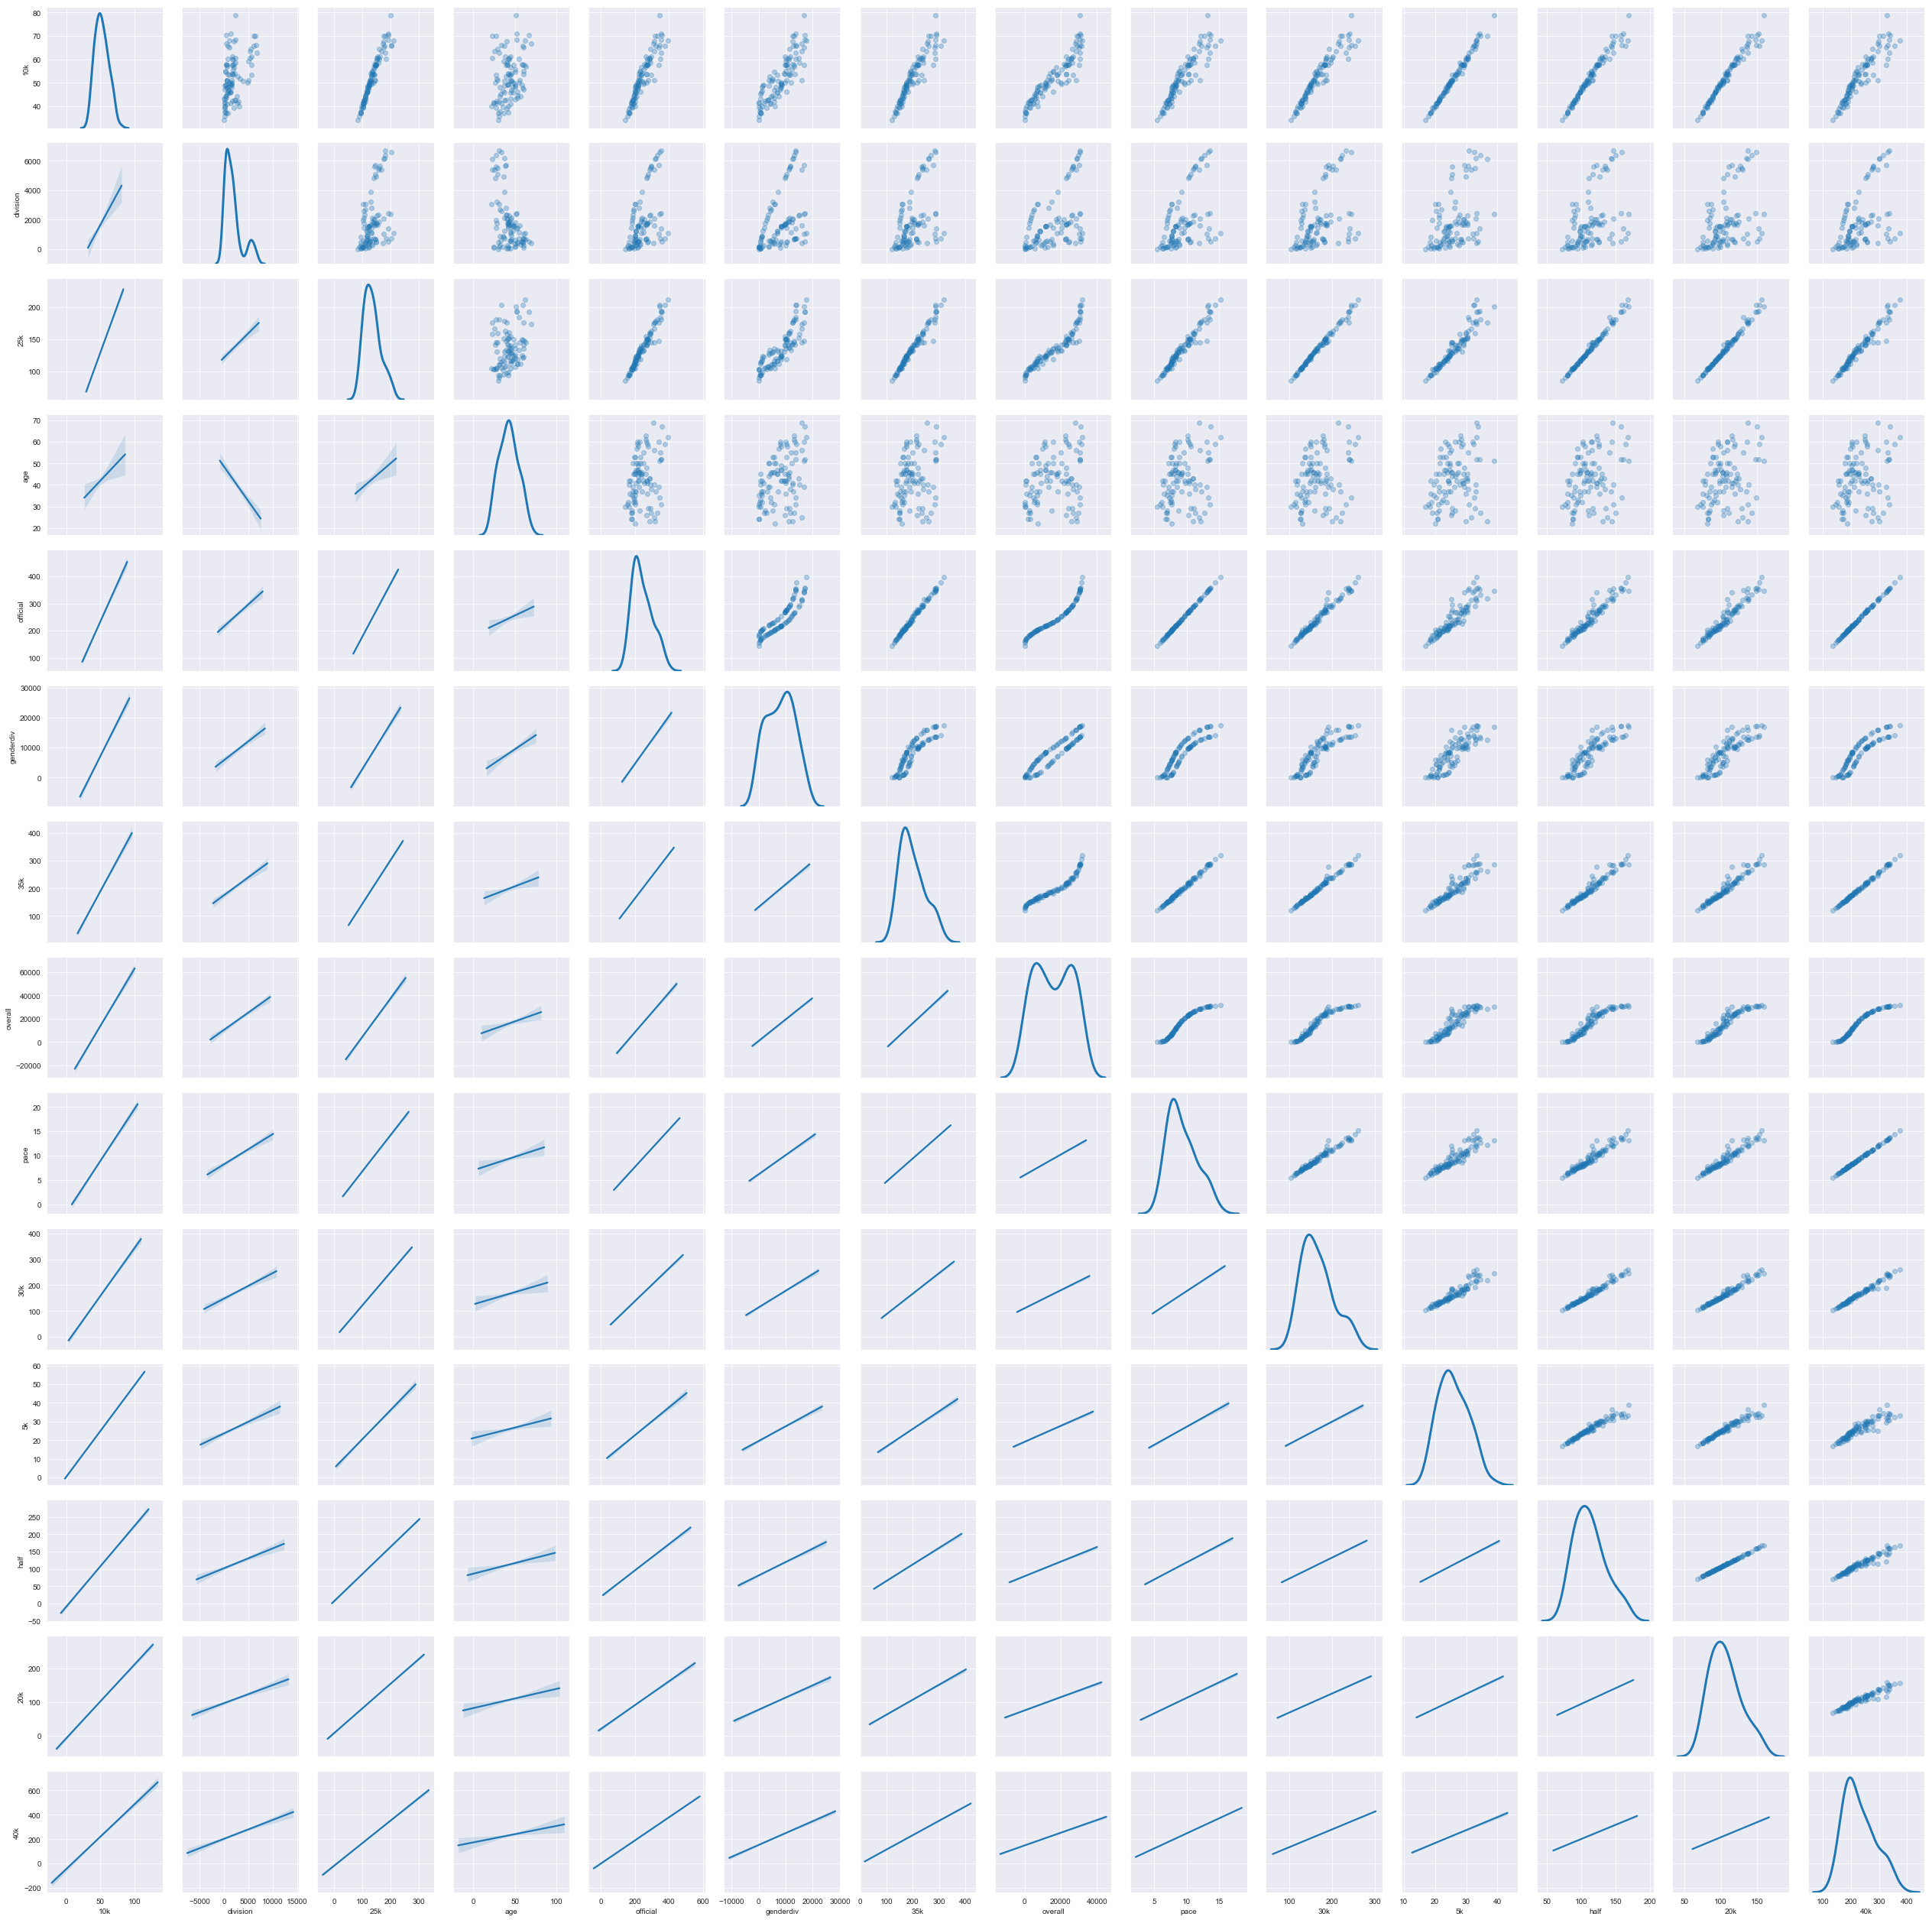

CPU times: user 1min 1s, sys: 5.69 s, total: 1min 7s
Wall time: 31 s


In [8]:
%%time

### Creating Scatterplot Matrix with Sample of DataFrame

## Store samples of DataFrame For Visualization

df_sample = df.sample(100)

## Declare Pairgrid
g = sns.PairGrid(df_sample.dropna().drop('bib',axis=1), diag_sharey=False)

## Scatterplot
g.map_upper(plt.scatter, alpha=.3)

## Fit line 
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

## KDE plot
g.map_diag(sns.kdeplot, lw=3)
plt.show()

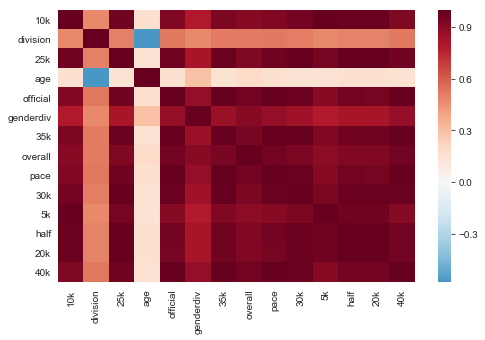

In [9]:

## Visualizing the Correlatedness of the Continuous variables

fig, ax = plt.subplots(figsize=(8,5))         
sns.heatmap(df.corr(), cmap='RdBu_r', center=0)
plt.show()

Large amounts of the variables were correlated since the performances in each event were directly related.

In [10]:
print('Length of dataframe: ' + str(len(df)) + '\n')
print('Number of unique name values: ' + str(df.name.nunique()))
print('Number of unique official values: ' + str(df.official.nunique()))
print('Number of unique bib values: ' + str(df.bib.nunique()))
print('Number of unique country values: ' + str(df.country.nunique()))
print('Number of unique city values: ' + str(df.city.nunique()))

Length of dataframe: 29103

Number of unique name values: 29044
Number of unique official values: 10568
Number of unique bib values: 29103
Number of unique country values: 2
Number of unique city values: 4648


Variables with very large numbers of classes may not be palatable to clustering methods.

In [11]:
df.gender.value_counts()

M    15578
F    13525
Name: gender, dtype: int64

In [12]:
df.country.value_counts()

USA    26939
CAN     2164
Name: country, dtype: int64

In [13]:
%%time
## Descriptive Statistics of All Continuous Variables
df.describe()

CPU times: user 87 ms, sys: 9.76 ms, total: 96.7 ms
Wall time: 53.5 ms


,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000,29103.000
mean,51.827,1966.941,134.107,42.054,242.813,8008.426,196.772,15980.929,9.269,164.525,25.779,111.640,105.729,229.038
std,8.704,1732.203,25.628,11.348,50.922,4733.456,40.870,9169.894,1.942,32.965,4.207,20.334,19.186,48.165
min,17.120,1.000,48.550,18.000,84.820,1.000,70.830,1.000,3.250,59.770,8.020,40.200,38.020,80.180
25%,45.580,623.500,115.920,33.000,205.980,3954.500,167.550,8074.500,7.870,141.075,22.730,97.180,92.070,194.280
50%,50.430,1445.000,129.230,42.000,232.570,7923.000,188.400,15997.000,8.880,157.980,25.150,108.020,102.350,219.120
75%,57.200,2703.500,148.430,50.000,273.310,11908.500,220.270,23946.000,10.430,183.125,28.500,123.200,116.650,257.780
max,112.380,6979.000,289.020,81.000,538.880,17575.000,449.330,31931.000,20.570,376.380,86.950,236.670,224.350,508.350


## Preparing The Data For Clustering

In [14]:
%%time

## Remove Columns With Low Significance

df = df.drop(['name', 'official', 'bib', 'city'] ,axis=1)

CPU times: user 2.89 ms, sys: 261 µs, total: 3.15 ms
Wall time: 3.13 ms


These variables were dropped because they had a large number of unique classes and wouldn't serve as a good basis to make distinctions.

In [15]:
%%time

## Store Data and Create Training and Testing Groups

X = df

X_train_, X_test_= train_test_split(
    X,
    test_size=0.2,
    random_state=42)

X_train = pd.get_dummies(X_train_)
X_test = pd.get_dummies(X_test_)

## Display New Number of Features

print('Number of Features: '+ str(len(X_train.columns)))

Number of Features: 84
CPU times: user 43.1 ms, sys: 5.11 ms, total: 48.2 ms
Wall time: 47.1 ms


## Using Clustering Methods to Label the Datasets

### Mean Shift

In [16]:
%%time

bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}\n".format(n_clusters_))

Number of estimated clusters: 2

CPU times: user 17.8 s, sys: 267 ms, total: 18.1 s
Wall time: 18.1 s


In [17]:
%%time

## Computing a Sillhouette Score For the Mean Shift

print('Silhouette Score for Mean Shift with 2 Clusters: ' + str(silhouette_score(X_train, labels)) + '\n')

Silhouette Score for Mean Shift with 2 Clusters: 0.48946078123171577

CPU times: user 13.4 s, sys: 1.53 s, total: 14.9 s
Wall time: 9.14 s


### K Means

In [18]:
%%time

## Choosing Appropriate Number of Clusters

print('Silhouette scores for K Means:\n')
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    print(str(n_clusters) + ' clusters: ' + str(silhouette_score(X_train, KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X_train))))
print('\n')

Silhouette scores for K Means:

2 clusters: 0.5740618914389091
3 clusters: 0.4964724184220665
4 clusters: 0.4380862592380197
5 clusters: 0.39158331261513585
6 clusters: 0.3546366444540107


CPU times: user 1min 18s, sys: 9.26 s, total: 1min 27s
Wall time: 47.1 s


Mean Shift settled on two clusters and the silhouette score for K means was highest when it had two clusters. For these reasons it is safe to assume that 2 clusters would be appropriate for analyzing the dataset. Since the highest score came from clustering with K means, the data will be analyzed with respect to divisions made using K means with 2 clusters.

## Analyzing Clusters Made Using K Means

In [19]:
%%time

## Calculate predicted values.

y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_train)

CPU times: user 1.75 s, sys: 229 ms, total: 1.98 s
Wall time: 499 ms


In [20]:
%%time

## Create A Dataframe Using The Original Dataset and New Labels

df_kmeans = X_train_
df_kmeans['labels'] = y_pred

## Split Results by New Labels

df_kmeans_0 = df_kmeans.loc[df_kmeans['labels'] == 0]
df_kmeans_1 = df_kmeans.loc[df_kmeans['labels'] == 1]


CPU times: user 336 ms, sys: 32.3 ms, total: 369 ms
Wall time: 162 ms


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Cluster labels were assigned to the original dataset and that dataset was split by label for further analysis. Each cluster is referred to as cluster 0 and cluster 1 (denoting the label given to the respective groups of observations).

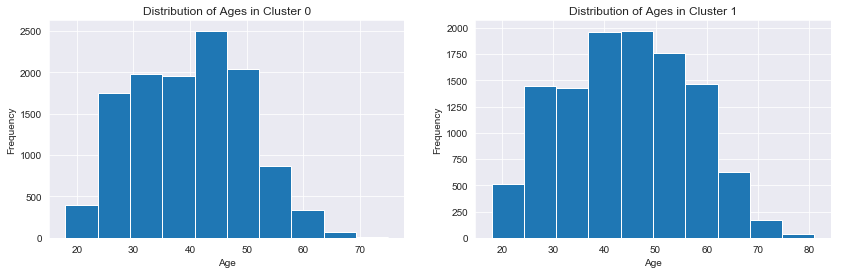

CPU times: user 800 ms, sys: 72.4 ms, total: 872 ms
Wall time: 388 ms


In [21]:
%%time

fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(hspace=.5)

## Histogram of Trip Distances

plt.subplot(1, 2, 1)
ax = df_kmeans_0.age.plot(kind='hist', title="Distribution of Ages in Cluster 0")
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")

## Histogram of Trip Durations

plt.subplot(1, 2, 2)
ax = df_kmeans_1.age.plot(kind='hist', title="Distribution of Ages in Cluster 1")
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")


plt.show()

While the two distributions do have a similar shape, there are a few details worth noting. Cluster 0 has a larger amount of younger (under 50) patricipants while cluster 1 has a larger number of older participants. The peak frequency in terms of age for cluster 0 was around the 45 to 50 age range. This implies that there is a shift regarding this age group that may cause a participant to be more likely to fall within cluster 1.

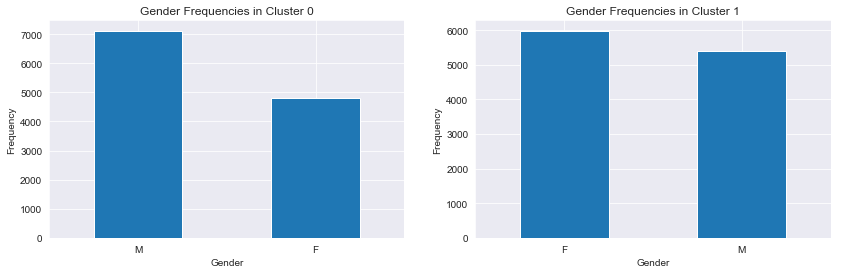

CPU times: user 735 ms, sys: 84.2 ms, total: 820 ms
Wall time: 301 ms


In [22]:
%%time

fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(hspace=.5)

## Histogram of Trip Distances

plt.subplot(1, 2, 1)
ax = df_kmeans_0.gender.value_counts().plot(kind='bar', title="Gender Frequencies in Cluster 0")
ax.set_xlabel("Gender")
ax.set_ylabel("Frequency")
plt.xticks(rotation=0)

## Histogram of Trip Durations

plt.subplot(1, 2, 2)
ax = df_kmeans_1.gender.value_counts().plot(kind='bar', title="Gender Frequencies in Cluster 1")
ax.set_xlabel("Gender")
ax.set_ylabel("Frequency")
plt.xticks(rotation=0)

plt.show()

An observation is likely to fall into cluster 1 if the participant was a female. Since this distinction is stronger than that made by the age groups, it could be said that gender is a stronger indicator of grouping and that age may simply have a relationship with gender (e.g. Older females may simply be more likely to enter the race than younger females).

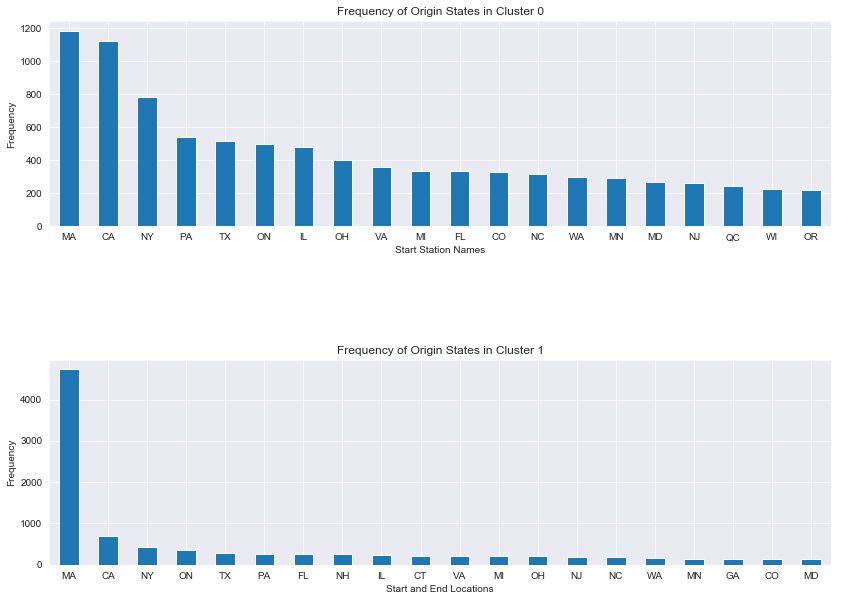

CPU times: user 1.3 s, sys: 119 ms, total: 1.42 s
Wall time: 667 ms


In [23]:
%%time

## Barplot of Frequency of use of Specific Starting Stations 

fig = plt.figure(figsize=(14, 10))
fig.subplots_adjust(hspace=.65)

plt.subplot(2, 1, 1)
ax = df_kmeans_0.state.value_counts().head(20).plot(kind='bar',
                                    
                                    title="Frequency of Origin States in Cluster 0")
ax.set_xlabel("Start Station Names")
ax.set_ylabel("Frequency")
plt.xticks(rotation=0)

## Barplot of Frequency of use of Specific Ending Stations 

plt.subplot(2, 1, 2)
ax = df_kmeans_1.state.value_counts().head(20).plot(kind='bar',
                                    
                                    title="Frequency of Origin States in Cluster 1")
ax.set_xlabel("Start and End Locations")
ax.set_ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

The strongest categorical distinction by far is that of origin state. Members of cluster 1 were overwhelmingly from Massachusetts while, members of cluster 0 had much more dispersed origins. There are many factors that could relate a person's state to their performance and likelihood to participate in the event but clustering has shown that a lot of them can be encompassed in the state variable. This doesn't preclude the importance of other strong distinctions (such as gender, where large quantities of both genders do exist in both groups, albeit in different quantities).

In [25]:
df_kmeans_0[['10k', 'division', '25k', 'age', 'genderdiv', '35k', 'overall', 'pace',
       '30k', '5k', 'half', '20k', '40k']].describe()

,10k,division,25k,age,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,11906.000,11906.000,11906.000,11906.000,11906.000,11906.000,11906.000,11906.000,11906.000,11906.000,11906.000,11906.000,11906.000
mean,45.466,1223.351,115.132,40.037,4224.341,165.759,8192.376,7.770,139.868,22.730,96.647,91.596,191.981
std,4.431,1016.309,11.185,9.901,2669.670,16.289,4751.032,0.771,13.657,2.235,9.355,8.870,19.017
min,17.120,1.000,48.550,18.000,1.000,70.830,1.000,3.250,59.770,8.020,40.200,38.020,80.180
25%,42.470,406.000,107.123,32.000,1979.000,154.430,4121.500,7.250,130.173,21.250,90.050,85.350,179.123
50%,45.820,919.000,116.270,40.000,4016.000,167.970,8195.500,7.880,141.470,22.870,97.570,92.450,194.730
75%,48.680,1793.750,123.530,47.000,6045.500,178.270,12239.750,8.380,150.200,24.280,103.650,98.227,206.895
max,58.980,3833.000,145.370,75.000,9992.000,197.530,17116.000,9.020,170.180,31.730,123.520,116.820,224.400


In [26]:
df_kmeans_1[['10k', 'division', '25k', 'age', 'genderdiv', '35k', 'overall', 'pace',
       '30k', '5k', 'half', '20k', '40k']].describe()

,10k,division,25k,age,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,11376.000,11376.000,11376.000,11376.000,11376.000,11376.000,11376.000,11376.000,11376.000,11376.000,11376.000,11376.000,11376.000
mean,58.438,2734.330,153.866,44.245,11945.950,229.074,24058.158,10.829,190.205,28.945,127.250,120.444,267.575
std,7.010,1978.200,21.294,12.381,2841.006,33.371,4521.959,1.538,27.297,3.347,16.756,15.813,38.429
min,36.870,1.000,97.220,18.000,6240.000,154.220,15089.000,8.750,121.430,18.350,79.900,75.630,185.220
25%,53.520,1154.750,138.100,34.000,10024.750,202.280,20211.750,9.570,169.250,26.600,115.150,109.050,236.250
50%,57.380,2073.000,149.130,45.000,11985.500,221.470,24139.500,10.500,184.080,28.580,123.740,117.170,259.070
75%,62.730,4595.250,166.105,54.000,13945.000,248.720,27978.250,11.780,205.920,31.050,136.980,129.630,291.250
max,102.820,6979.000,289.020,81.000,17575.000,449.330,31931.000,20.570,376.380,51.980,236.670,224.350,508.350


Mean performances generally were within one standard deviation of the median for both groups. Due to the nature of the data, there is a limit on how low values related to race times can be (due to physical limitations). In addition to this, large outliers do exist due to people who may have had significantly a harder time finishing an event. Overall, cluster 1 had higher performances across all events. This could be related to the home state of the participants in the sense that natives may perform better in a marathon held in their own state compared to non natives (since cluster 0 contained higher quantities  of people from other states).

## Conclusion

Clustering with K means proved useful for making distinctions between different types of runners. One group had more more males, people who aren't from Massachisetts, and low performers. The other had more females, Massachusetts natives, and high performers. While there may be a relationship between these qualities, the groups didn't exclusively consist of people of a specific quality. The sharpest distinction was based on home state, which to an extent may influence other variables.
